# МТС ШАД NN image competition


In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import torchvision.models as models
import torch.optim as optim
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [4]:
labels_pd = pd.read_csv('/kaggle/input/nn-image/train_labels.csv')

In [5]:
le = LabelEncoder()
labels_pd['label_num'] = le.fit_transform(labels_pd['label'])

In [6]:
label_dict = dict(zip(labels_pd['label_num'], labels_pd['label']))

### Dataset


In [7]:
class Pocemon(Dataset):
    def __init__(self, root_dir, label_file=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        label_file['filename'] = label_file['filename'].str.strip() 

        for img_name in os.listdir(root_dir):
            if img_name.lower().endswith('.jpg'):
                img_path = os.path.join(root_dir, img_name)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    label = label_file[label_file['filename'] == img_name]['label_num']
                    if len(label) == 1:
                        self.labels.append(int(label.item()))
                    else:
                        self.labels.append(0)  

        print(f"Found {len(self.image_paths)} images in {root_dir}")
        if not self.image_paths:
            print("No images found")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, img_path

### Augmentation

In [8]:
# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7686, 0.7905, 0.7852], std=[0.2833, 0.2559, 0.2585]),
])

hor_flip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7686, 0.7905, 0.7852], std=[0.2833, 0.2559, 0.2585]),
])

rand_rot = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7686, 0.7905, 0.7852], std=[0.2833, 0.2559, 0.2585]),
])

rand_persp = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7686, 0.7905, 0.7852], std=[0.2833, 0.2559, 0.2585]),
])

In [9]:
train_path = '/kaggle/input/nn-image/train_test_data/train/'
test_path = '/kaggle/input/nn-image/train_test_data/test/'

original_dataset = Pocemon(root_dir=train_path, label_file=labels_pd, transform=transform)

hor_dataset = Pocemon(root_dir=train_path, label_file=labels_pd, transform=hor_flip)
rot_dataset = Pocemon(root_dir=train_path, label_file=labels_pd, transform=rand_rot)
persp_dataset = Pocemon(root_dir=train_path, label_file=labels_pd, transform=rand_persp)

train_dataset = ConcatDataset([original_dataset, hor_dataset, rot_dataset, persp_dataset])

test_dataset = Pocemon(root_dir=test_path, label_file=labels_pd, transform=transform)

Found 4773 images in /kaggle/input/nn-image/train_test_data/train/
Found 4773 images in /kaggle/input/nn-image/train_test_data/train/
Found 4773 images in /kaggle/input/nn-image/train_test_data/train/
Found 4773 images in /kaggle/input/nn-image/train_test_data/train/
Found 2046 images in /kaggle/input/nn-image/train_test_data/test/


### DataLoaders

In [11]:
train, val = random_split(train_dataset, [int(len(train_dataset) * 0.8 + 1), int(len(train_dataset) * 0.2)])

train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers=4)

train_model_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [12]:
def show_images(images, labels, nrow=4):
    # Переводим тензоры изображений в numpy массивы
    images = images.numpy()
    labels = labels.numpy()

    # Создаем фигуру
    fig, axes = plt.subplots(nrow, nrow, figsize=(5, 5))

    # Проходимся по всем изображениям в батче
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = np.transpose(images[i], (1, 2, 0))

            # Денормализация изображения
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(f'{label_dict[labels[i]]}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

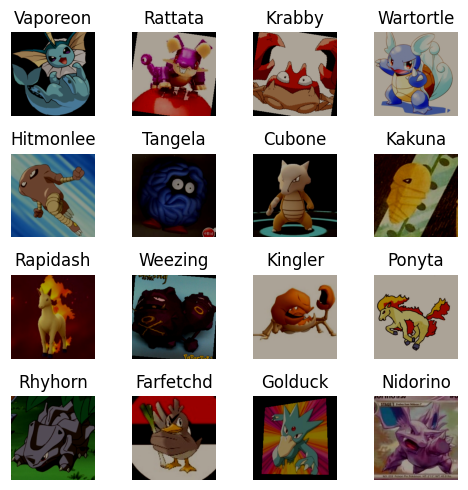

In [13]:
for images, labels, _ in train_loader:
    show_images(images, labels, nrow=4)
    break

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Models

#### Своя архитектура

In [15]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.avgpool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**После теста нескольких архитектур, была выбрана densenet201**

In [16]:
num_classes = 151

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet201(weights=None, ) 
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

model = model.to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Model Train

In [17]:
model = models.densenet201(weights=None) 
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for inputs, labels, _ in train_model_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_model_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


 10%|█         | 1/10 [04:58<44:50, 298.95s/it]

Epoch 1/10, Loss: 3.6180


 20%|██        | 2/10 [10:00<40:03, 300.38s/it]

Epoch 2/10, Loss: 2.2987


 30%|███       | 3/10 [15:02<35:07, 301.12s/it]

Epoch 3/10, Loss: 1.3242


 40%|████      | 4/10 [20:04<30:08, 301.47s/it]

Epoch 4/10, Loss: 0.6966


 50%|█████     | 5/10 [25:06<25:08, 301.75s/it]

Epoch 5/10, Loss: 0.3621


 60%|██████    | 6/10 [30:08<20:07, 301.80s/it]

Epoch 6/10, Loss: 0.2298


 70%|███████   | 7/10 [35:10<15:05, 301.87s/it]

Epoch 7/10, Loss: 0.1453


 80%|████████  | 8/10 [40:12<10:03, 301.82s/it]

Epoch 8/10, Loss: 0.1489


 90%|█████████ | 9/10 [45:13<05:01, 301.66s/it]

Epoch 9/10, Loss: 0.1067


100%|██████████| 10/10 [50:14<00:00, 301.48s/it]

Epoch 10/10, Loss: 0.0969


In [21]:
model.eval()
file_names = []
predictions = []

with torch.no_grad():
    for inputs, _, paths in tqdm(test_loader):
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        file_names.extend([os.path.basename(path) for path in paths])

submission_df = pd.DataFrame({
    'filename': file_names,
    'label': predictions
})


100%|██████████| 64/64 [00:16<00:00,  3.91it/s]


### Submission

In [23]:
submission_df['label_text'] = submission_df['label'].map(label_dict)
submission_df['filename'] = submission_df['filename'].apply(os.path.basename)

submission_df[['filename', 'label_text']].to_csv('subm.csv', index=False)